In [1]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [2]:
df =pd.read_sql_table('cloud', 'sqlite:///dissertation.db') 

In [3]:
df_copy = df.copy()

In [4]:
df_copy

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
0,2019-12-23 00:00:00,89.5,-1,0,0,0,weekday,0.000249
1,2019-12-23 00:00:10,88.0,-1,0,0,0,weekday,0.000244
2,2019-12-23 00:00:20,88.5,-1,0,0,0,weekday,0.000246
3,2019-12-23 00:00:30,88.5,-1,0,0,0,weekday,0.000246
4,2019-12-23 00:00:40,88.5,-1,0,0,0,weekday,0.000246
...,...,...,...,...,...,...,...,...
1451515,2020-06-07 23:59:10,133.0,23,6,23,59,holiday,0.000369
1451516,2020-06-07 23:59:20,133.0,23,6,23,59,holiday,0.000369
1451517,2020-06-07 23:59:30,136.0,23,6,23,59,holiday,0.000378
1451518,2020-06-07 23:59:40,133.5,23,6,23,59,holiday,0.000371


In [5]:
# group by half an hour, and change kWh to Wh in order to enlarge the number
df_half = pd.DataFrame ({'Half_Wh':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [6]:
df_half

,Half_Wh
time,
2019-12-23 00:00:00,44.387500
2019-12-23 00:30:00,44.506944
2019-12-23 01:00:00,44.395833
2019-12-23 01:30:00,44.356944
2019-12-23 02:00:00,44.329167
...,...
2020-06-07 21:30:00,66.773611
2020-06-07 22:00:00,66.802778
2020-06-07 22:30:00,66.730556


In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [11]:
# subset data until lockdown 23/03/2020  (13 weeks * 7day * 48 points =4368)
subset = 4368
df_train_test = df_half[['Half_Wh']][:subset]
df_simu = df_half[['Half_Wh']][subset:]

# transform 
train_test=df_train_test.values
train_test=train_test.astype('float32')

simu=df_simu.values
simu=simu.astype('float32')

In [12]:
# split into train and test sets
train_size = int(len(train_test) * 0.65)
test_size = len(train_test) - train_size
train, test = train_test[0:train_size], train_test[train_size:len(train_test)]
print(len(train), len(test))

2839 1529


In [13]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
look_back=1
trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test,look_back)
simuX, simuY = create_dataset(simu,look_back)

In [15]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=1, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae'])
history=model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 2s - loss: 22.3787 - mse: 22.3786 - mae: 1.4413
Epoch 2/200
 - 2s - loss: 0.1069 - mse: 0.1069 - mae: 0.0991
Epoch 3/200
 - 1s - loss: 0.1124 - mse: 0.1124 - mae: 0.1110
Epoch 4/200
 - 2s - loss: 0.1194 - mse: 0.1194 - mae: 0.1256
Epoch 5/200
 - 2s - loss: 0.1274 - mse: 0.1274 - mae: 0.1393
Epoch 6/200
 - 1s - loss: 0.1266 - mse: 0.1266 - mae: 0.1405
Epoch 7/200
 - 1s - loss: 0.1296 - mse: 0.1296 - mae: 0.1425
Epoch 8/200
 - 1s - loss: 0.1343 - mse: 0.1343 - mae: 0.1421
Epoch 9/200
 - 1s - loss: 0.1250 - mse: 0.1250 - mae: 0.1413
Epoch 10/200
 - 1s - loss: 0.1264 - mse: 0.1264 - mae: 0.1368
Epoch 11/200
 - 2s - loss: 0.1294 - mse: 0.1294 - mae: 0.1429
Epoch 12/200
 - 2s - loss: 0.1274 - mse: 0.1274 - mae: 0.1404
Epoch 13/200
 - 1s - loss: 0.1232 - mse: 0.1232 - mae: 0.1330
Epoch 14/200
 - 1s - loss: 0.1234 - mse: 0.1234 - mae: 0.1321
Epoch 15/200
 - 1s 

Epoch 124/200
 - 1s - loss: 0.1199 - mse: 0.1199 - mae: 0.1288
Epoch 125/200
 - 1s - loss: 0.1240 - mse: 0.1240 - mae: 0.1317
Epoch 126/200
 - 2s - loss: 0.1220 - mse: 0.1220 - mae: 0.1244
Epoch 127/200
 - 1s - loss: 0.1226 - mse: 0.1226 - mae: 0.1344
Epoch 128/200
 - 1s - loss: 0.1216 - mse: 0.1216 - mae: 0.1356
Epoch 129/200
 - 1s - loss: 0.1213 - mse: 0.1213 - mae: 0.1276
Epoch 130/200
 - 1s - loss: 0.1238 - mse: 0.1238 - mae: 0.1386
Epoch 131/200
 - 1s - loss: 0.1251 - mse: 0.1251 - mae: 0.1308
Epoch 132/200
 - 2s - loss: 0.1228 - mse: 0.1228 - mae: 0.1240
Epoch 133/200
 - 1s - loss: 0.1218 - mse: 0.1218 - mae: 0.1292
Epoch 134/200
 - 2s - loss: 0.1197 - mse: 0.1197 - mae: 0.1235
Epoch 135/200
 - 1s - loss: 0.1271 - mse: 0.1271 - mae: 0.1358
Epoch 136/200
 - 1s - loss: 0.1184 - mse: 0.1184 - mae: 0.1255
Epoch 137/200
 - 1s - loss: 0.1209 - mse: 0.1209 - mae: 0.1307
Epoch 138/200
 - 1s - loss: 0.1245 - mse: 0.1245 - mae: 0.1323
Epoch 139/200
 - 1s - loss: 0.1216 - mse: 0.1216 - mae:

In [16]:
# model evalute
trainScore = model.evaluate(trainX, trainY)
testScore = model.evaluate(testX, testY)
#validScore = model.evaluate(validX, validY)

print('Train MSE: ', trainScore[1], 'MAE: ', trainScore[2])
print('Test MSE: ', testScore[1], 'MAE: ', testScore[2])
#print('Valid MSE: ', validScore[1], 'MAE: ', validScore[2])

1527/1527 [==============================] - 0s 25us/step
Train MSE:  0.1022309809923172 MAE:  0.07215236127376556
Test MSE:  0.17588001489639282 MAE:  0.08263655751943588


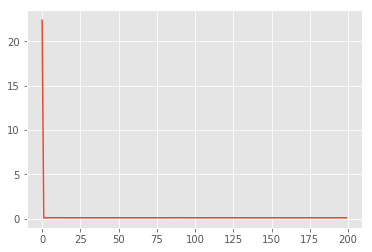

In [17]:
plt.plot(history.history['loss'])

In [18]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
simuPredict = model.predict(simuX)
nextPredict = model.predict(testX[-1:,:])

In [19]:
print(nextPredict,df_simu[0:1].values)

[[60.38813]] [[60.42361111]]


In [20]:
from sklearn.metrics import r2_score
r2_score(testY,testPredict)

0.9891419559561578

In [ ]:
time = np.arange('2019-12-23 00:00:00','2020-06-08 00:00:00', dtype='datetime64[30m]')

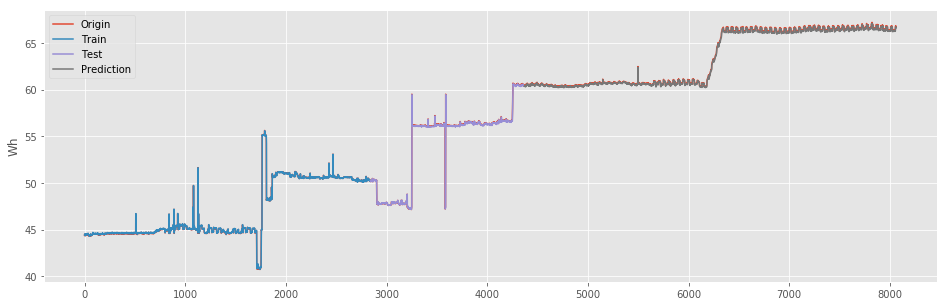

In [21]:
trainPredictPlot = np.empty_like(train_test)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(train_test)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train_test)-1, :] = testPredict

np_all = np.concatenate((train_test,simu),axis=0)
simuPredictPlot = np.empty_like(np_all)
simuPredictPlot[:, :] = np.nan
simuPredictPlot[len(train_test)+look_back:-1, :] = simuPredict


#add time range

# plot baseline and predictions
plt.figure(figsize=(16,5))
plt.plot(np_all,label='Origin')
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Test')
plt.plot(simuPredictPlot,label='Prediction')
plt.legend()
plt.ylabel('Wh')
plt.show()

In [23]:
# plot graph with time in xaxis, add time and plot
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_all = pd.DataFrame(np_all,columns={'Actual'}).set_index(time_index)
df_trainPredictPlot = pd.DataFrame(trainPredictPlot,columns={'Train'}).set_index(time_index[:subset])
df_testPredictPlot = pd.DataFrame(testPredictPlot,columns={'Test'}).set_index(time_index[:subset])
df_simuPredictPlot = pd.DataFrame(simuPredictPlot,columns={'Prediction'}).set_index(time_index)
df_all_plot = pd.concat([df_all, df_trainPredictPlot,df_testPredictPlot,df_simuPredictPlot], axis=1)

Text(0, 0.5, 'Wh')

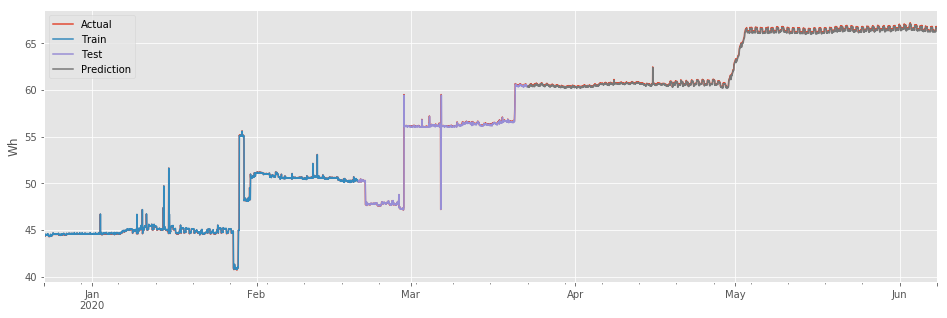

In [26]:
df_all_plot.set_index(df_all_plot.index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

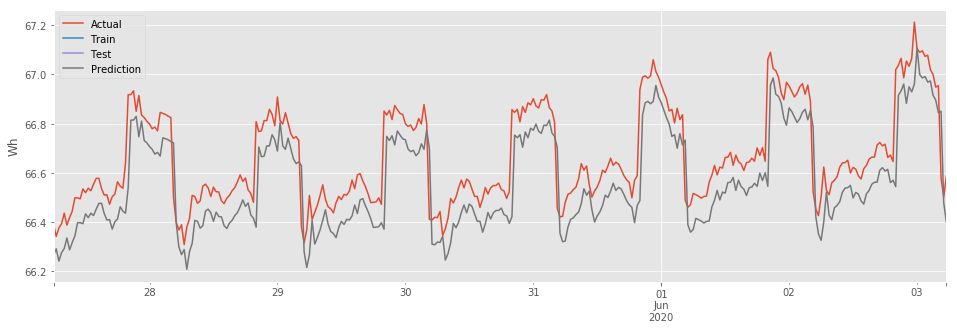

In [27]:
df_all_plot[7500:7836].set_index(df_all_plot[7500:7836].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

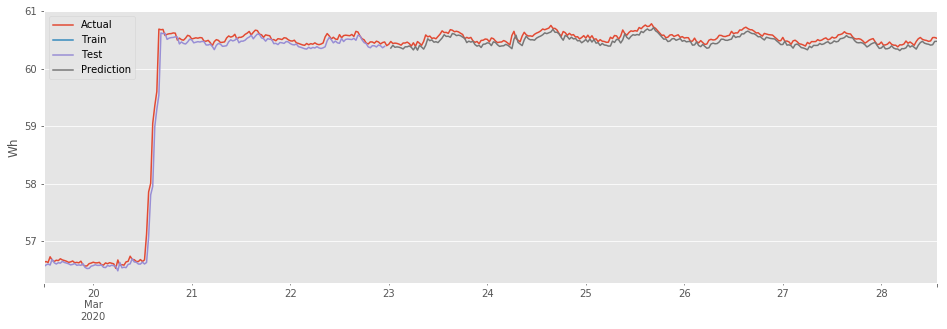

In [28]:
df_all_plot[4200:4636].set_index(df_all_plot[4200:4636].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

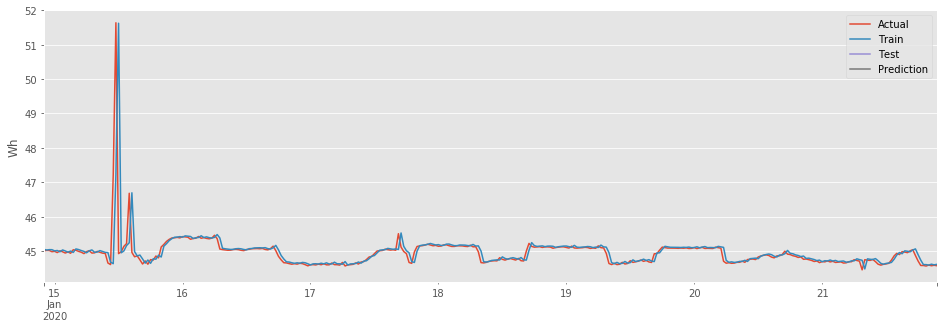

In [29]:
df_all_plot[1100:1436].set_index(df_all_plot[1100:1436].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [25]:
# save the model 
model.save('cloud_nolock_ann.h5')

In [6]:
# with lockdown
mad_mean_ratio =0.0826*1529/df_half['Half_Wh'][4368-1613:4368].sum() 
mad_mean_ratio

0.0014450714189557631